In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import interp1d
import seaborn as sns
from scipy.stats import linregress
from scipy.stats.mstats import gmean
import scipy
from scipy import stats

import random
import deepdiff

from collections import Counter

import funcs_analysis as fa
  


Notes for running the analysis functions in the 41 server:

* To run the functions in the 41 server you can just copy and paste them in a $file.py$.
* To read the data you will need to redefine the path in which the data is located.
* To visualize the plots you will need to save them as png or as pdf. You can also save the dataframes as csv files.


# Read data
Total number of patients : 58  

In [2]:
#Read replanned patients

#Define path: Redefine path for 41 server
path="~/Documents/Medical_Physics/min_dist_PTV_body/min_dist_ind_pats/"

pats_R=["19", "35", "115", "272", "447", "454", "459", "462","77","118","467","390","474","476","484","487","490", "452", "22", "103","506",
"439", "469","473","478","483","453","471","54","81"] #patient replanned individual

pats_NR=["464","468","359","169","456","451","443","146","425","432","172","43","509","504","440","153","257","436","466",
"147","458","503","510","23","424","498","514","515"]

all_patients=pats_R+pats_NR

#Note: If you run read_data in the 41 server, you would use:
#prefix_pat_num --> min_dist_pat
print("read replanned patients")
df,df_min=fa.read_data(path,pats_R,"pat_")
print("\nread not replanned patients")
df_NR,df_min_NR=fa.read_data(path,pats_NR,"pat_")

read replanned patients
# patients: 30

read not replanned patients
# patients: 28


# Defining dictionaries 
We will use the dictionaries to find the fraction of replan for each patient and to distinguish between patients that should have been replanned and patients actually replanned.
* keys: replanned patients
* dict_actual_replan values: replan fractions or Julia's fraction of replan
* dict_replan_request: fraction of determination of replan (FDR) 
* dict_shbr: replanned (r), should have been replanned (shbr)

In [3]:
#Fraction in which they were replanned or Julia's fraction of replan
dict_actual_replan={'19':'21','35':'26','54':'22','81':'21','118':'24','272':'25','447':'23','454':'12','459':'11','462':'22','467':'22',
'469':'15','473':'20','474':'27','478':'19','483':'20','77':'5','115':'12','390':'19','439':'22','453':'23','471':'24','476':'12','484':'16','487':'12','490':'20',
'452':'17','520':'7','22':'13','103':'9','506':'25'}

#Fraction in which they the replan request was issued or Julia's fraction of replan
dict_replan_request={'19':'15','35':'20','54':'15','81':'14','118':'20','272':'19','447':'19','454':'3','459':'4','462':'15','467':'14',
'469':'14','473':'16','474':'17','478':'15','483':'15','77':'5','115':'12','390':'19','439':'22','453':'23','471':'24',
'476':'12','484':'16','487':'12','490':'20','452':'17','520':'7','22':'13','103':'9','506':'25'}


#Patients labeling as replanned (r) or should have been replanned (shbr) 
dict_shbr={'19':'r','35':'r','54':'r','81':'r','118':'r','272':'r','447':'r','454':'r','459':'r','462':'r','467':'r',
'469':'r','473':'r','474':'r','478':'r','483':'r','77':'shbr','115':'shbr','390':'shbr','439':'shbr','453':'shbr','471':'shbr','476':'shbr',
'484':'shbr','487':'shbr','490':'shbr','452':'r','520':'r','22':'shbr','103':'shbr','506':'shbr'}



We want to create an algorithm that will be able to predict replanning using the rate of change of Body - PTV minimum distance. This may be possible because the distribution between replanned and not replanned patients are significantly different (p<0.001) from fraction 7 to 25 as illustrated in the violin plot below.

Text(0, 0.5, 'slope values')

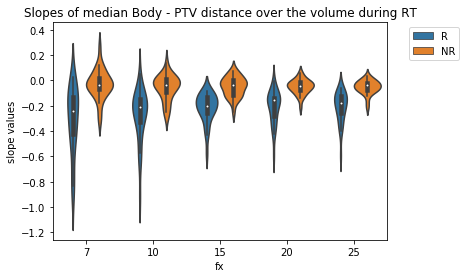

In [4]:
all_slopes_df=fa.get_all_slopes_fx(df,df_NR,8,27)
sns.violinplot(x="fx",y="slope_values",hue="replanned_or_not",data=all_slopes_df)
plt.title("Slopes of median Body - PTV distance over the volume during RT")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel("slope values")

The p - values were calculated using a Mann Whitney U test and the results are in the table below.

In [5]:
p_values_median=fa.get_p_values(df,df_NR,"median",0.001)
p_values_median

,max_fraction,p_value_median,p(median) <0.001
0,5,4.073547e-02,no
1,6,4.298792e-03,no
2,7,1.466816e-05,yes
3,8,2.513067e-06,yes
4,9,1.464714e-06,yes
5,10,1.354734e-06,yes
6,11,1.583253e-06,yes
7,12,1.072869e-07,yes
8,13,2.292781e-07,yes
9,14,2.292781e-07,yes


We decided to use the slopes intersection range
to determine the classification thresholds.

In [6]:
sir=fa.df_slopes_intersection_range(df,df_NR,26)#slopes intersection range
sir

,fractions,intersection range,replan threshold,no replan threshold
0,7,"(-0.49, 0.18)",-0.49,0.18
1,8,"(-0.32, 0.03)",-0.32,0.03
2,9,"(-0.32, 0.02)",-0.32,0.02
3,10,"(-0.29, 0.05)",-0.29,0.05
4,11,"(-0.29, 0.05)",-0.29,0.05
5,12,"(-0.25, 0.05)",-0.25,0.05
6,13,"(-0.26, -0.08)",-0.26,-0.08
7,14,"(-0.26, -0.08)",-0.26,-0.08
8,15,"(-0.25, -0.08)",-0.25,-0.08
9,16,"(-0.25, -0.08)",-0.25,-0.08


We divided the data in test and training. Classification thresholds were calculated using train data and predictions were calculated for test data. 
The test patients were classified acording to their slope at every fraction during radiotherapy. The classification labels were issued as following: 
* Slope < replan threhold --> replan
* Slope > no replan threhold --> no replan
* Else --> assess (no prediction can be made)

Different criteria were used to evaluate our algorithm.

## Evaluation criteria 1. 

True positive = accurate prediction from algorithm at least once

### EC.1.1. The algorithm does not take into account the slope's standard error for the test data

In [7]:
dr_1,pats_R_sel_1,pats_NR_sel_1=fa.get_predictions_df(df,df_NR,dict_replan_request,multi_t=False,std_error_slope=False)
print("Ground truth\n")
print("Replanned patients:\n",pats_R_sel_1)
print("Not replanned patients:\n",pats_NR_sel_1)
print("\n\n Predictions")
dr_1.head(9)

Ground truth

Replanned patients:
 ['19', '272', '447', '467', '484', '487', '490', '452', '469', '473', '453']
Not replanned patients:
 ['359', '443', '146', '432', '172', '504', '257']


 Predictions


,fractions,359,443,146,432,172,504,257,19,272,447,467,484,487,490,452,469,473,453
0,7,no CBCT,no CBCT,assess,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,assess,assess,assess,no CBCT,no CBCT,assess,assess,assess
1,8,assess,no replan,no CBCT,assess,no CBCT,no replan,assess,assess,no CBCT,assess,no CBCT,no CBCT,no CBCT,assess,no CBCT,no CBCT,no CBCT,no CBCT
2,9,no CBCT,no CBCT,assess,no CBCT,assess,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,assess,no CBCT,no replan,no CBCT,assess,replan,assess,replan
3,10,no CBCT,no CBCT,no CBCT,assess,no CBCT,no replan,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,assess,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT
4,11,assess,no CBCT,no replan,no CBCT,no CBCT,no CBCT,no CBCT,assess,replan,assess,no CBCT,no CBCT,no CBCT,assess,assess,no CBCT,no CBCT,no CBCT
5,12,no CBCT,no CBCT,no CBCT,no replan,no CBCT,no CBCT,assess,no CBCT,no CBCT,no CBCT,assess,assess,assess,no CBCT,no CBCT,replan,assess,assess
6,13,no CBCT,no CBCT,no CBCT,no CBCT,no replan,no replan,no CBCT,replan,no CBCT,assess,no CBCT,no CBCT,no CBCT,assess,assess,no CBCT,no CBCT,no CBCT
7,14,assess,no replan,no replan,no CBCT,no CBCT,no CBCT,assess,no CBCT,no CBCT,no CBCT,assess,replan,assess,no CBCT,assess,no CBCT,assess,no CBCT
8,15,no CBCT,no CBCT,no CBCT,no replan,no CBCT,no replan,assess,replan,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,assess


### EC.1.2. The algorithm does takes into account the slope's standard error for the test data

In [8]:
dr_2,pats_R_sel_2,pats_NR_sel_2=fa.get_predictions_df(df,df_NR,dict_replan_request,multi_t=False,std_error_slope=True)
print("Ground truth\n")
print("Replanned patients:\n",pats_R_sel_2)
print("Not replanned patients:\n",pats_NR_sel_2)
print("\n\n Predictions")
dr_2.head(9)

Ground truth

Replanned patients:
 ['19', '35', '272', '447', '467', '390', '474', '476', '487', '490', '452', '22', '478', '471', '54']
Not replanned patients:
 ['509', '440', '503']


 Predictions


,fractions,509,440,503,19,35,272,447,467,390,474,476,487,490,452,22,478,471,54
0,7,assess,assess,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,assess,assess,no CBCT,no CBCT,assess,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT
1,8,no CBCT,assess,assess,assess,no CBCT,no CBCT,assess,no CBCT,no CBCT,replan,no CBCT,no CBCT,assess,no CBCT,no CBCT,replan,replan,assess
2,9,assess,assess,no CBCT,no CBCT,assess,no CBCT,no CBCT,assess,assess,no CBCT,assess,no replan,no CBCT,assess,assess,no CBCT,no CBCT,no CBCT
3,10,no CBCT,assess,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT
4,11,no CBCT,assess,assess,assess,assess,assess,assess,no CBCT,assess,assess,no CBCT,no CBCT,assess,assess,assess,assess,assess,assess
5,12,assess,assess,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,assess,no CBCT,no CBCT,assess,assess,no CBCT,no CBCT,no CBCT,no CBCT,assess,no CBCT
6,13,no CBCT,assess,no replan,assess,assess,no CBCT,assess,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,assess,assess,assess,no CBCT,no CBCT,assess
7,14,assess,no replan,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,assess,assess,assess,assess,assess,no CBCT,assess,no CBCT,no CBCT,no CBCT,assess
8,15,no CBCT,no CBCT,no CBCT,replan,assess,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,no CBCT,replan,replan,no CBCT


# Evaluating predictions using accuracy, precision and recall 
* Test data: 18 random patients
* Train data: 40 patients

Eval functions inspired on: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall


### Evaluation criteria 2.
Identifies if the algorithm predicts true positive values, true negatives, false positives or false negatives at least once during RT. Assess values are counted as patients with no prediction. 

In [9]:
eval_preds_1=fa.create_df_eval_preds(df,df_NR,5,fa.count_pats_true_positives_false_neg_1,dict_replan_request,multi_t=False)
eval_preds_1

,Trial,# R,# nR,true positives,false negatives,no prediction R,true negatives,false positives,no prediction NR
0,0,10,8,9,0,1,5,3,0
1,1,8,10,5,1,2,9,0,1
2,2,10,8,6,1,4,7,0,1
3,3,10,8,9,0,1,5,4,0
4,4,11,7,7,1,4,7,0,0


In [10]:
fa.get_eval_paramenters(eval_preds_1,18)

total accuracy (%) 77.0
total precision 63.0
total recall 73.0
patients with no prediction (%) 16.0
predictive accuracy (%) 88.0
predictive precision 89.0
predictive recall 91.0


### Evaluation criteria 3. 
Identifies if the algorithm $first$ predictions are true positive values, true negatives, false positives or false negatives. The first predictions are the first values different from assess.

In [11]:
eval_preds_2=fa.create_df_eval_preds(df,df_NR,5,fa.count_pats_true_positives_false_neg_2,dict_replan_request,multi_t=False)
eval_preds_2

,Trial,# R,# nR,true positives,false negatives,no prediction R,true negatives,false positives,no prediction NR
0,0,11,7,9,1,1,6,1,0
1,1,9,9,7,1,1,6,2,1
2,2,8,10,6,0,2,5,3,2
3,3,7,11,5,0,2,7,1,3
4,4,11,7,8,1,2,6,0,1


In [12]:
fa.get_eval_paramenters(eval_preds_2,18)

total accuracy (%) 72.0
total precision 62.0
total recall 76.0
patients with no prediction (%) 17.0
predictive accuracy (%) 87.0
predictive precision 84.0
predictive recall 93.0


### Evaluation criteria 4.
Same conditions than criteria 3 to calculate true negatives and false negatives. However, a value was a true positive only if the fraction of replan predicted $\leq$ fraction of replan. 

#### Fraction of replan = fraction of dtermination of the replan

In [13]:
n_times=5
df_eval_new=fa.create_df_pred_2(df,df_NR,0,dict_replan_request,multi_t=False)
for n in range(1,n_times):
    df_eval=fa.create_df_pred_2(df,df_NR,n,dict_replan_request,multi_t=False)
    df_eval_new=df_eval_new.append(df_eval)
    
df_eval_new=df_eval_new.reset_index()
df_eval_new

,index,Trial,# R,# nR,true positives,false negatives,no prediction R,true negatives,false positives,no prediction NR
0,0,0,11,7,3,0,1,5,1,1
1,0,1,8,10,1,2,3,7,3,0
2,0,2,9,9,3,2,3,6,2,1
3,0,3,9,9,1,1,1,7,2,0
4,0,4,10,8,1,3,3,4,4,0


In [14]:
fa.get_eval_paramenters(df_eval_new,18)

total accuracy (%) 42.0
total precision 27.0
total recall 19.0
patients with no prediction (%) 14.000000000000002
predictive accuracy (%) 67.0
predictive precision 43.0
predictive recall 54.0


#### Fraction of replan = Start of M1P1 or Julia's replan labels fx

In [15]:
n_times=5
df_eval_new_2=fa.create_df_pred_2(df,df_NR,0,dict_actual_replan,multi_t=False)
for n in range(1,n_times):
    df_eval=fa.create_df_pred_2(df,df_NR,n,dict_actual_replan,multi_t=False)
    df_eval_new_2=df_eval_new_2.append(df_eval)
    
df_eval_new_2=df_eval_new_2.reset_index()

In [16]:
df_eval_new_2

,index,Trial,# R,# nR,true positives,false negatives,no prediction R,true negatives,false positives,no prediction NR
0,0,0,10,8,2,0,0,5,3,0
1,0,1,13,5,8,0,1,4,0,1
2,0,2,7,11,1,1,1,8,2,1
3,0,3,6,12,1,2,2,9,2,1
4,0,4,10,8,3,1,1,7,0,1


In [17]:
fa.get_eval_paramenters(df_eval_new_2,18)

total accuracy (%) 53.0
total precision 43.0
total recall 28.000000000000004
patients with no prediction (%) 10.0
predictive accuracy (%) 81.0
predictive precision 61.0
predictive recall 72.0


# Some plots 
We want to know in which fraction most patients needed a replan. In fraction of determination of the replan (FDR) histogram, most patients needed a replan at fraction 15 and just a few patients needed a replan before fraction 10.

Text(0.5, 0, 'Fraction of determination of the replan')

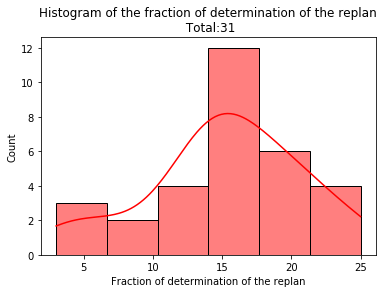

In [18]:
replan_values=list(dict_replan_request.values())
replan_values=[int(a) for a in replan_values]
sns.histplot(replan_values,kde="True",color="red")
plt.title("Histogram of the fraction of determination of the replan\n Total:"+str(len(dict_replan_request)))
plt.xlabel("Fraction of determination of the replan")

In the histogram of slopes at FDR, we can see that most replanned patients has a negative slope with the exception of a few outlier patients that had a positive slope. It may be that those patients volume increased rather than decreased. 

patients slope above 0:
454
459
patients slope below 0.5:
77
478


Text(0.5, 0, 'slope values')

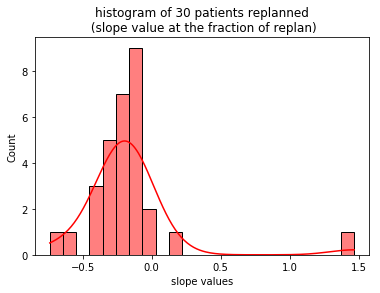

In [19]:
pats,slopes_R=fa.get_replan_fx_per_pat(df,dict_replan_request)
print("patients slope above 0:") 
fa.get_patients_above_threshold(0,pats_R,slopes_R)
print("patients slope below 0.5:") 
fa.get_patients_below_threshold(-0.5,pats,slopes_R)
sns.histplot(slopes_R,color="red",label="slopes R - at fx replan",kde="True")
plt.title("histogram of "+ str(len(pats_R))+" patients replanned\n (slope value at the fraction of replan)")
plt.xlabel("slope values")

We will plot the median minimum Body - PTV distance during RT for to understand what happened with the "outlier patients". An interesting characteristic of those patients is that the replan request or Julia's replan labels was issued really early for the following fractions (fx $\leq 7$).

fraction of determination of the replan:  3


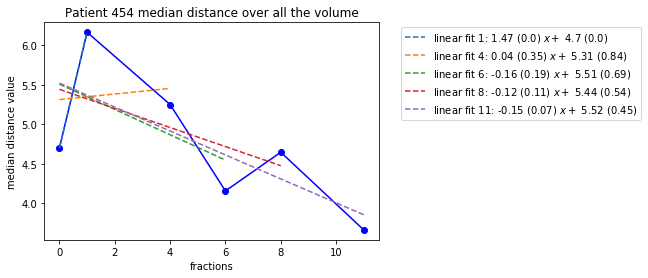

In [20]:
fa.plot_pat_slopes("454",df,1)
print("fraction of determination of the replan: ",dict_replan_request["454"])

fraction of determination of the replan:  4


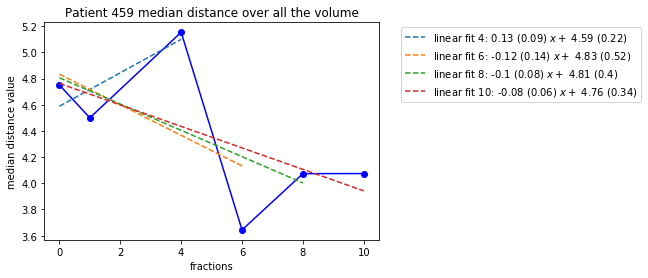

In [21]:
fa.plot_pat_slopes("459",df,2)
print("fraction of determination of the replan: ",dict_replan_request["459"])

Notes: We have to approach the problem differently. 

We analyze only the replanned patients with negative slopes for now.

patients slope above 0:
454
459
patients slope below -0.5:
77
478


Text(0.5, 0, 'slope values')

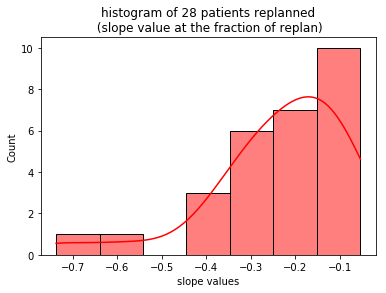

In [22]:
#remove patients with positive slope 
pats_R_ps,slopes_R_ps=fa.get_pat_neg_slope(pats_R,slopes_R)
#pats_R_clean,slopes_R_clean=fa.remove_pat(pats,slopes_R,["459","454"])
#pats,slopes_R=fa.get_replan_fx_per_pat(df,dict_replan_request)
print("patients slope above 0:") 
fa.get_patients_above_threshold(0,pats,slopes_R)
print("patients slope below -0.5:") 
fa.get_patients_below_threshold(-0.5,pats,slopes_R)
sns.histplot(slopes_R_ps,color="red",label="slopes R - at fx replan",kde="True")
plt.title("histogram of "+ str(len(pats_R_ps)) +" patients replanned\n (slope value at the fraction of replan)")
plt.xlabel("slope values")

Now, we want to calculate the replan threholds in a different way. We want to compare the slopes at FDR to the not replanned patients slopes for different fractions. 

In the violin plot illustrated  below we can see that the slopes range decrease as the patient recieves more dose fractions.

Mann Whitney U test results
5 fx: p<0.005 True
10 fx: p<0.005 True
15 fx: p<0.005 True
20 fx: p<0.005 True
25 fx: p<0.005 True


-0.28609539121565397

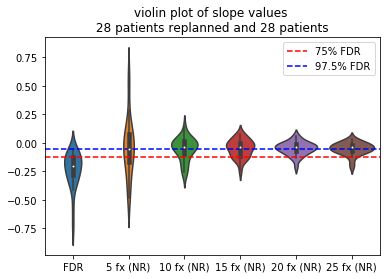

In [23]:
df_fx_r_nr=fa.df_slopes_fx_replan(slopes_R_ps,df_NR)#28 R pat & 28 NR pat
df_ndr=list(df_fx_r_nr.loc[:,"FDR"])
nr_fx_cols=list(df_fx_r_nr.columns)
nr_fx_cols.remove("FDR")

sns.violinplot(data=df_fx_r_nr)
plt.title("violin plot of slope values \n 28 patients replanned and 28 patients ")
plt.axhline(np.quantile(df_ndr, 0.75), color="red", linestyle='--', label="75% FDR")
plt.axhline(np.quantile(df_ndr, 0.975), color="blue", linestyle='--', label="97.5% FDR")
plt.legend()

print("Mann Whitney U test results")

for i in nr_fx_cols:
    

    df_nr=list(df_fx_r_nr.loc[:,i])
    p_value=scipy.stats.mannwhitneyu(df_ndr,df_nr).pvalue
    print(int(i[0:2]),"fx: p<0.005",p_value<0.005)
    
np.quantile(df_ndr, 0.25)

The histograms below are equivalent to the violin plots above.

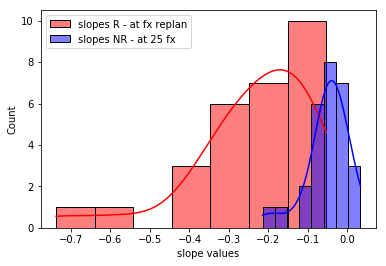

In [47]:
slopes_NR=fa.find_slopes_stats(df_NR,25)
sns.histplot(slopes_R_ps,color="red",label="slopes R - at fx replan",kde="True")
sns.histplot(slopes_NR,color="blue",label="slopes NR - at 25 fx ",kde="True")
plt.xlabel("slope values")
plt.legend()

# patients replanned: 28
# patients not replanned 28


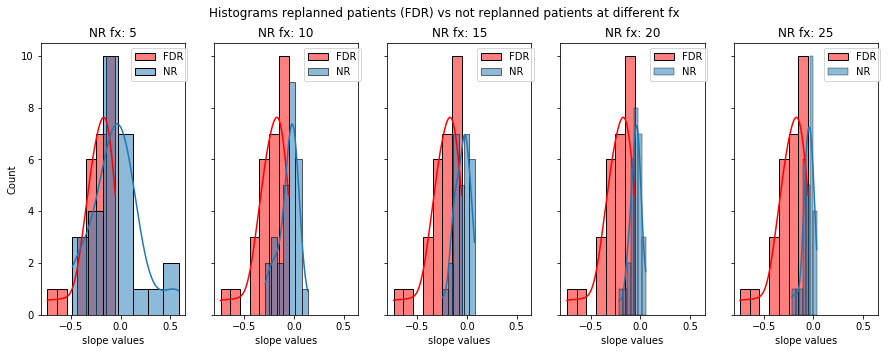

In [24]:
fa.plot_slopes_fx_replan(slopes_R_ps,df_NR,26)
print("# patients replanned:",len(slopes_R_ps))
print("# patients not replanned",len(df_NR.columns))


We split the replanned data in patients actually replanned (R), patients that should have been replanned (SHBR) and patients not replanned (NR) for for visualization purposes. That way we are able to see that the SHBR patients are right on the middle of the replanned and not replanned patients. This confirms the hypothesis that they were not replanned because they may be more difficult to identify than the patients that were actually replanned. 

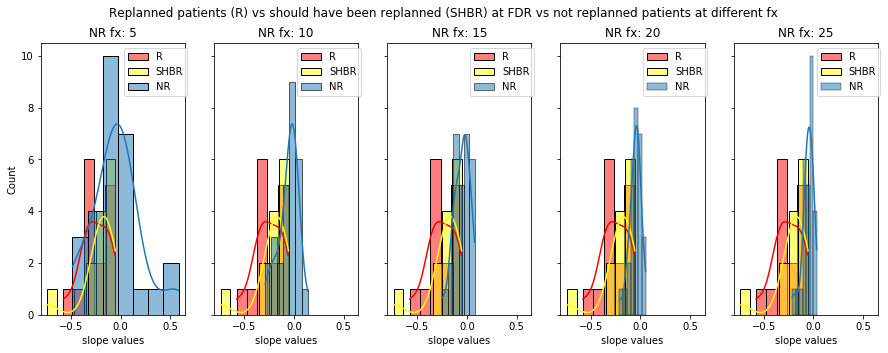

In [25]:
pats_shbr, slopes_shbr, pats_r, slopes_r=fa.split_r_and_shbr(pats_R_ps,slopes_R_ps,dict_shbr)
fa.plot_slopes_fx_shbr(slopes_r,slopes_shbr,df_NR,26)

Now we want to calculate the new thresholds ($t_i$) for replan and not replan. We will add a third threshold ($t_3$) to identify replans due to a gain in weight.

* if slope < $t_1$: replan
* if slope > $t_2$ AND slope < $t_3$: noreplan
* if slope > $t_3$: replan

Here is an example of how to find the thresholds for fraction 15.


In [26]:
slopes_NR_fx=fa.find_slopes_stats(df_NR,15)
range_R_left,range_R_right=np.round(fa.range_list(slopes_R_ps),2)

range_NR_left,range_NR_right=np.round(fa.range_list(slopes_NR_fx),2)

print("range of intersection at fraction 15: ("+str(range_NR_left)+","+str(range_R_right)+")")

print("\nthresholds at 15 fx:\n")
print("threshold 1 (t1): "+str(range_NR_left))
print("threshold 2 (t2): "+str(range_R_right))
print("threshold 3 (t3): "+str(range_NR_right))




range of intersection at fraction 15: (-0.25,-0.05)

thresholds at 15 fx:

threshold 1 (t1): -0.25
threshold 2 (t2): -0.05
threshold 3 (t3): 0.11


In [27]:
sir=fa.df_multi_thresholds(df,df_NR,25,dict_replan_request)

In [35]:
sir

,fractions,t1,t2,t3
0,7,-0.49,-0.05,0.26
1,8,-0.32,-0.05,0.26
2,9,-0.32,-0.05,0.26
3,10,-0.29,-0.05,0.14
4,11,-0.29,-0.05,0.14
5,12,-0.25,-0.05,0.11
6,13,-0.26,-0.05,0.11
7,14,-0.26,-0.05,0.11
8,15,-0.25,-0.05,0.11
9,16,-0.25,-0.05,0.08


In [33]:
pred_3,pats_R_sel_3,pats_NR_sel_3 =fa.get_predictions_df(df,df_NR,dict_replan_request,multi_t=True,std_error_slope=False)
pred_3

In [37]:
n_times=5
df_eval_new_4=fa.create_df_pred_2(df,df_NR,0,dict_actual_replan,multi_t=True)
for n in range(1,n_times):
    df_eval=fa.create_df_pred_2(df,df_NR,n,dict_actual_replan,multi_t=True)
    df_eval_new_4=df_eval_new_4.append(df_eval)
    
df_eval_new_4=df_eval_new_4.reset_index()

In [38]:
df_eval_new_4

,index,Trial,# R,# nR,true positives,false negatives,no prediction R,true negatives,no prediction NR,false positives
0,0,0,12,6,6,0,1,5,1,0
1,0,1,9,9,3,0,0,8,0,1
2,0,2,9,9,3,0,0,7,1,1
3,0,3,9,9,4,1,2,7,0,2
4,0,4,12,6,5,1,2,4,0,2


In [39]:
fa.get_eval_paramenters(df_eval_new_4,18)

total accuracy (%) 57.99999999999999
total precision 63.0
total recall 41.0
patients with no prediction (%) 8.0
predictive accuracy (%) 87.0
predictive precision 78.0
predictive recall 93.0
